### 1-Mount Google drive

In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')
#BASE_DIR = '/gdrive/My Drive/AN2DL/'

### 2-Import Libraries

In [1]:
import os, datetime, warnings, logging, random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras,cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from keras import layers
from keras import models
from keras import optimizers
from tqdm.notebook import tqdm
import glob, random, time, shutil
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D, BatchNormalization, Activation, Input, Add, Dense, ZeroPadding2D,Flatten, AveragePooling2D, Rescaling, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras import metrics
from joblib import Parallel, delayed
from sklearn.preprocessing import label_binarize, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback,ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from zipfile import ZipFile

In [2]:
#loading the model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetV2_preprocessing
from tensorflow.keras.models import load_model

In [3]:
# For snapshot Ensemble
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

### 3-Read DATA

In [4]:
dataset_dir = "./public_data.zip"
dataset_folder = "./dataset"

# checking if the dataset folder already exists
if not os.path.exists(dataset_folder):
    # extracting all the files
    with ZipFile(dataset_dir, 'r') as zip:
        print('Extracting all the files now...')
        zip.extractall(path=os.getcwd())
        os.getcwd()
        print('Done!')

Extracting all the files now...
Done!


In [5]:
dataset = np.load("./public_data.npz", allow_pickle=True)

### 4-Fix randomness and hide warnings

In [6]:
# Fix randomness and hide warnings
SEED = 42

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

np.random.seed(SEED)

import logging

random.seed(SEED)

### 5-Set first parameters of tensorflow

In [7]:
# Import tensorflow
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
print("tensorflow_version",tf.__version__)

tensorflow_version 2.9.2


### 6-EDA On Dataset

In [8]:
keys = list(dataset.keys())
print('keys in our dataset are: ', keys)

#data shape
images = dataset["data"]
no_images = images.shape[0]
size_images = images.shape[1:3]
print('Data shape: ',images.shape)

#labels
labels = dataset["labels"]
no_labels = labels.shape[0]

#check balanced or imbalanced of DATA
unique_classes, counts = np.unique(labels,return_counts=True)
#for cls, count in zip(unique_classes, counts):
#    print(f"Class {cls}: {count} data points")

keys in our dataset are:  ['data', 'labels']
Data shape:  (5200, 96, 96, 3)


### 7_Show images

In [9]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the string labels to integer labels
integer_labels = label_encoder.fit_transform(labels)

# Convert integers to binary labels (0 or 1)
binary_labels = np.where(integer_labels == 1, 1, 0)

In [10]:
def show_images(dataset, labels, batch_no, no_images_per_batch, num_cols=10):

    start_index = batch_no * no_images_per_batch
    end_index = min((batch_no + 1) * no_images_per_batch, len(dataset))
    num_rows = (end_index - start_index + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    for i, ax in enumerate(axes.ravel()):
        if start_index + i < end_index:
            image = dataset[start_index + i]
            image = image / 255.0  # Normalize pixel values to [0, 1]
            ax.imshow(image)
            ax.set_title(f"{labels[start_index + i]}",fontsize=10, y=-0.5)
            ax.axis('off')

    for i in range(end_index - start_index, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.show()

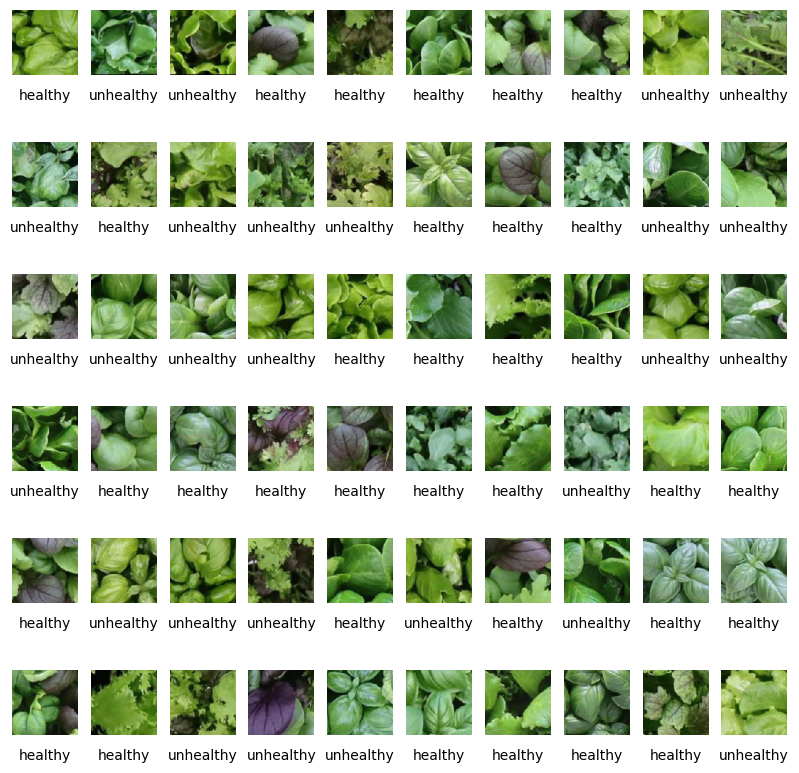

In [11]:
show_images(dataset=images,labels =labels, batch_no=60,no_images_per_batch=60)

### 8-Remove Outliers

In [12]:
# As you understood there are some uselees images in dataset which must be first recognized and then remoeved.

def histogram_similarity(image, reference_histogram, threshold=0.8):

    # Calculate the color histogram of the image
    image_histogram = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(image_histogram, image_histogram)
    intersection = cv2.compareHist(reference_histogram, image_histogram, cv2.HISTCMP_INTERSECT)

    return intersection < threshold


# Load a reference histogram from a non-Shrek-Singer image
reference_image = images[0]  # Use the first image as a reference which it's a leaf image
reference_histogram = cv2.calcHist([reference_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
cv2.normalize(reference_histogram, reference_histogram)

similarity_threshold = 0.62
odd_images = []

# Iterate through the images in data_array
for image in images:
    if histogram_similarity(image, reference_histogram, similarity_threshold):
        odd_images.append(image)

In [13]:
#Creating reference images
reference_unwanted_images = []

# Define the index of the image we want to plot and save as a reference
image_index_trololo = 10  # Replace with the index of the reference image
image_index_shrek = 33

if 0 <= image_index_trololo  and image_index_shrek< len(odd_images):
    # Get the image based on the index
    trololo_reference_image = odd_images[image_index_trololo]
    shrek_reference_image = odd_images[image_index_shrek]

    reference_unwanted_images.append(trololo_reference_image)
    reference_unwanted_images.append(shrek_reference_image)

else:
    print("Invalid image index.")

In [14]:
from skimage.color import rgb2lab, deltaE_cie76

#Calculate the color distance between two images using the CIE76 metric.
def calculate_color_distance(image1, image2):

    lab_image1 = rgb2lab(image1)
    lab_image2 = rgb2lab(image2)

    return deltaE_cie76(lab_image1, lab_image2)

def find_unwanted_images_by_color_distance(data_array, reference_unwanted_images, color_distance_threshold):

    cleaned_data = []
    unwanted_images = []
    labels_index =[]
    outlier_labels_index=[]
    index =0
    for image in data_array:
        similar = False
        for reference_image in reference_unwanted_images:
            color_distance = calculate_color_distance(image, reference_image)
            if (color_distance < color_distance_threshold).all():
                similar = True
                break  # No need to check further if a match is found
        if (similar == True):
            unwanted_images.append(image)
            labels_index.append(index)
        else:
            cleaned_data.append(image)
            outlier_labels_index.append(index)

        index+=1

    return cleaned_data,unwanted_images, labels_index

color_distance_threshold = 1

In [15]:
cleaned_images,unwanted_images, labels_index = find_unwanted_images_by_color_distance(images, reference_unwanted_images, color_distance_threshold)

In [16]:
unwanted_images = np.stack(unwanted_images, axis=0) # Define new shape for unwanted_images
unwanted_images.shape

(196, 96, 96, 3)

In [17]:
cleaned_images = np.stack(cleaned_images, axis=0)
cleaned_images.shape

(5004, 96, 96, 3)

In [18]:
# Create a boolean mask for the values to keep
mask = np.ones(binary_labels.shape[0], dtype=bool)
mask[labels_index] = False

cleaned_labels = binary_labels[mask]
outlier_labels=binary_labels[labels_index]
category_labels = to_categorical(cleaned_labels, num_classes=2)

In [19]:
# Count the number of cleanend healthy and unhealthy images
healthy_count = np.sum(cleaned_labels == 0)
unhealthy_count = np.sum(cleaned_labels == 1)

# Proof of imbalanced dataset: 
# num (labeled healthy) = 3/2 num (labeled unhealthy)
print(f"Number of healthy images: {healthy_count}")
print(f"Number of unhealthy images: {unhealthy_count}")

Number of healthy images: 3101
Number of unhealthy images: 1903


                          Unwanted Images                          

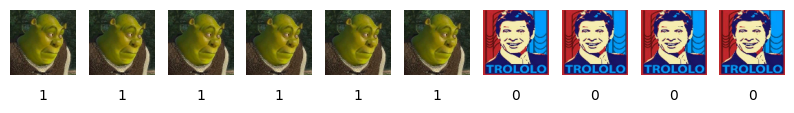

In [20]:
print(" "*25,end=" ")
print("Unwanted Images ",end=' '*25)
show_images(dataset=unwanted_images,labels=outlier_labels, batch_no=0,no_images_per_batch=10)

                          Cleaned Images                          

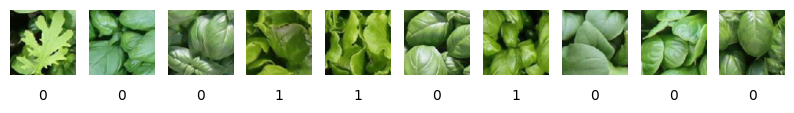

In [21]:
print(" "*25,end=" ")
print("Cleaned Images ",end=' '*25)
show_images(dataset=cleaned_images,labels =cleaned_labels, batch_no=0,no_images_per_batch=10)

In [22]:
no_images = cleaned_images.shape[0]
no_labels = cleaned_labels.shape[0]
_, counts = np.unique(cleaned_labels,return_counts=True) # count occurrence of each item
no_healthy_images = counts[0]
no_unhealthy_images = counts[1]

# pass variables to a dictionary to be used as dataframe for a better show
info_table_dict = {"no. images":no_images, "image width": size_images[0],"image length": size_images[1], "no. labels":no_labels,
                   "no. healthy_images":no_healthy_images,"percentage%":no_healthy_images*100/no_labels,
                   "no. unhealthy_images":no_unhealthy_images,"percentage %":no_unhealthy_images*100/no_labels }
print(" "*42,end=" ")
print("Our Table after Removing Outliers ",end=' '*42)
info_table = pd.DataFrame(info_table_dict, index =['value'])
info_table

                                           Our Table after Removing Outliers                                           

,no. images,image width,image length,no. labels,no. healthy_images,percentage%,no. unhealthy_images,percentage %
value,5004,96,96,5004,3101,61.970424,1903,38.029576


### 9-Splitting data

In [23]:
# # Constructor
# data_datagen = ImageDataGenerator(
#      #Data Augmentation
#     rotation_range=70,
#     height_shift_range=0.2,
#     width_shift_range=0.2, 
#      #shear_range=0.2, ##
#     zoom_range= 0.3,
#     horizontal_flip=True,
#     vertical_flip=True,
#     brightness_range=[0.8,1.2], ##[0.2 1.3]
#     # channel_shift_range=20,
#      fill_mode='reflect',
#      #rescale=1./255,
#     validation_split=0.1,
#     preprocessing_function = mobilenetV2_preprocessing
# )

# # Generator
# aug_train_set = data_datagen.flow(cleaned_images, cleaned_labels,
#     batch_size=64,
#     shuffle=True,
#     seed=SEED,
#     subset="training"
# )

# validation_set = data_datagen.flow(cleaned_images, cleaned_labels,
#     batch_size=64,
#     shuffle=True,
#     seed=SEED,
#     subset="validation"
# )
# print(f"Done!")



In [24]:
from keras.preprocessing.image import ImageDataGenerator

# Constructor for training data generator with augmentation
data_datagen_train = ImageDataGenerator(
    rotation_range=30,
    #height_shift_range=0.2,
    #width_shift_range=0.2,
    #zoom_range=[0.75 , 1.25 ],
    horizontal_flip=True,
    vertical_flip=True,
    #brightness_range=[0.6, 1.3],
    fill_mode='reflect',
    validation_split=0.1,  # This parameter is only used for splitting, not for validation data augmentation
    preprocessing_function=mobilenetV2_preprocessing
)

# Constructor for validation data generator without augmentation
data_datagen_val = ImageDataGenerator(
    validation_split=0.1,  # Use the same validation split
    preprocessing_function=mobilenetV2_preprocessing
)

# Generator for training set
aug_train_set = data_datagen_train.flow(
    cleaned_images,
    category_labels,
    batch_size=64,
    shuffle=True,
    seed=SEED,
    subset="training"
)

# Generator for validation set (without augmentation)
validation_set = data_datagen_train.flow(
    cleaned_images,
    category_labels,
    batch_size=64,
    shuffle=True,
    seed=SEED,
    subset="validation"
)

print(f"Done!")

Done!


### Compute the class weights to account for class imblancement

In [25]:
# unhealthy leaf ~ 2k, healthy leaf ~ 3k
from sklearn.utils import class_weight

class_weights = {1: 1.5, #unhealthy
                 0: 1}


### 10-Define Model -Transfer Learning

In [26]:
# Create MobileNetV2 model with specified settings
input_shape = (96, 96, 3)
mobile = tfk.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

9406464/9406464 [==============================] - 0s 0us/step
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [27]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer based on your input shape
input_layer = tfkl.Input(shape=input_shape)

# Connect MobileNetV2 to the input layer
x = mobile(input_layer)
x = tfkl.Flatten()(x)
# x = tfkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03))(x)
# x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tfkl.Dense(32, activation=None, kernel_initializer=tf.keras.initializers.HeUniform(SEED), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

x = tfkl.Dropout(0.2)(x)
x = tfkl.Dense(512, activation='relu')(x)
x = tfkl.Dropout(0.5)(x)
x = tfkl.Dense(128, activation=None, kernel_initializer = tf.keras.initializers.HeUniform(SEED))(x)

# # Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax' , kernel_initializer=keras.initializers.GlorotUniform(SEED) )(x)

# Create a Model connecting input and output
MobileNetV2_model = tf.keras.Model(inputs=input_layer, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
MobileNetV2_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
MobileNetV2_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 1280)             2257984   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [28]:
# Utility function for callbacks for training
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 10, verbose=1,factor=0.2, min_lr=0.000001)
# Model checkpoint
mcp_save_model_mobile = ModelCheckpoint('MobileNetV2_model.hdf5', save_best_only=True, monitor='accuracy', mode='max')

In [29]:
# Train the model
history_MobileNetV2_model = MobileNetV2_model.fit(
    aug_train_set,
    steps_per_epoch=len(aug_train_set),
    epochs=75,
    verbose=1,
    callbacks=[learning_rate_reduction, mcp_save_model_mobile],
    #callbacks=mcp_save_model_mobile,
    validation_data= validation_set,
    
    # corresponding to class imbalancement
    #class_weight=class_weights
)

Epoch 1/75
71/71 [==============================] - 15s 117ms/step - loss: 0.7864 - accuracy: 0.6745 - val_loss: 0.4600 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 2/75
71/71 [==============================] - 7s 101ms/step - loss: 0.4939 - accuracy: 0.7618 - val_loss: 0.4235 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 3/75
71/71 [==============================] - 7s 100ms/step - loss: 0.4879 - accuracy: 0.7664 - val_loss: 0.4168 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 4/75
71/71 [==============================] - 7s 103ms/step - loss: 0.4763 - accuracy: 0.7735 - val_loss: 0.3945 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 5/75
71/71 [==============================] - 7s 105ms/step - loss: 0.4585 - accuracy: 0.7804 - val_loss: 0.4130 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 6/75
71/71 [==============================] - 7s 103ms/step - loss: 0.4445 - accuracy: 0.7897 - val_loss: 0.3871 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 7/75
71/71 [==============================] - 7s 100ms/step - l

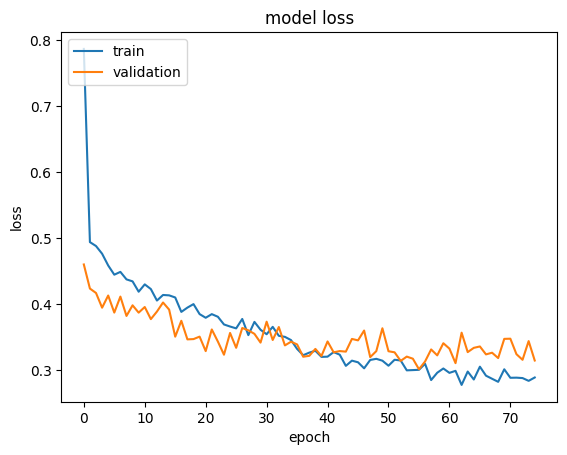

In [30]:
#plotting the validation and train loss
plt.plot(history_MobileNetV2_model.history['loss'])
plt.plot(history_MobileNetV2_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

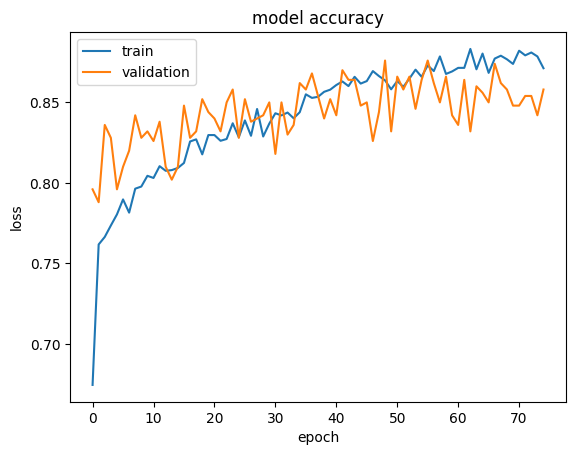

In [31]:
#plotting the validation and train ACC
plt.plot(history_MobileNetV2_model.history['accuracy'])
plt.plot(history_MobileNetV2_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the best model
MobileNetV2_model.save('TransferLearningModel')

del MobileNetV2_model

Covert the Model to Model.zip

In [ ]:
import os
import shutil

def zip_folder(folder_name, zip_name):
    try:
        shutil.make_archive(zip_name, 'zip', folder_name)
        print(f"Folder '{folder_name}' successfully zipped to '{zip_name}.zip'")
    except Exception as e:
        print(f"Error zipping folder: {e}")


folder_to_zip = 'TransferLearningModel'
zip_name = 'MobileNetModel-NoFinetune'

# Make sure the folder exists in the current directory
if os.path.exists(folder_to_zip):
    zip_folder(folder_to_zip, zip_name)
else:
    print(f"The folder '{folder_to_zip}' does not exist in the current directory.")

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until the 133rd one
N = 100
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

In [ ]:
# Model checkpoint
mcp_save_ft_model = ModelCheckpoint('ft_model.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

# Fine-tune the model
ft_history = ft_model.fit(
    aug_train_set,
    steps_per_epoch=len(aug_train_set),
    epochs=50,
    verbose=1,
    callbacks=[learning_rate_reduction, mcp_save_ft_model],
    validation_data= validation_set
)

In [ ]:
#plotting the validation and train loss
plt.plot(ft_history.history['loss'])
plt.plot(ft_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#plotting the validation and train ACC
plt.plot(ft_history.history['accuracy'])
plt.plot(ft_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Save FineTuned Model

In [ ]:
ft_model.save('mobilnet-finetune')

# Save Model in .zip
folder_to_zip = 'mobilnet-finetune'
zip_name = 'MobileNetModel-Finetuned'

# Make sure the folder exists in the current directory
if os.path.exists(folder_to_zip):
    zip_folder(folder_to_zip, zip_name)
else:
    print(f"The folder '{folder_to_zip}' does not exist in the current directory.")